In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 64
learning_rate = 0.0001

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='emotion5/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion5/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([64, 3, 48, 48])
out-size: torch.Size([3, 402, 402])


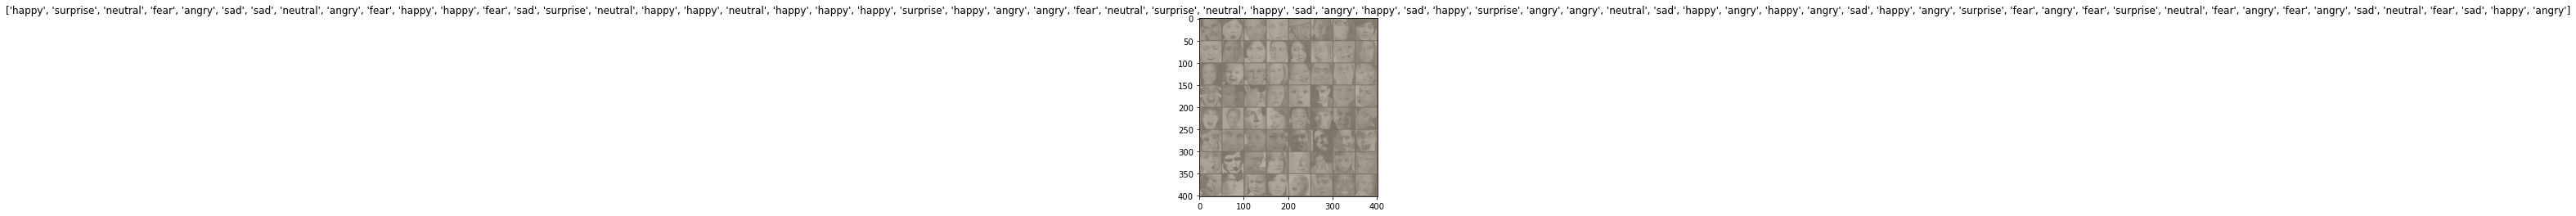

In [4]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [5]:
net = models.wide_resnet50_2(pretrained=False)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if device else net.fc

In [ ]:
n_epochs = 100
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'WideResnet50_adam_batch64_learninglr0.0001_nnlinear128_epoch100.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/100], Step [0/442], Loss: 5.4122
Epoch [1/100], Step [20/442], Loss: 3.7052
Epoch [1/100], Step [40/442], Loss: 2.7850
Epoch [1/100], Step [60/442], Loss: 2.0470
Epoch [1/100], Step [80/442], Loss: 1.9807
Epoch [1/100], Step [100/442], Loss: 1.9773
Epoch [1/100], Step [120/442], Loss: 1.8281
Epoch [1/100], Step [140/442], Loss: 1.9680
Epoch [1/100], Step [160/442], Loss: 1.7955
Epoch [1/100], Step [180/442], Loss: 1.8586
Epoch [1/100], Step [200/442], Loss: 1.9433
Epoch [1/100], Step [220/442], Loss: 1.9855
Epoch [1/100], Step [240/442], Loss: 1.7725
Epoch [1/100], Step [260/442], Loss: 1.6850
Epoch [1/100], Step [280/442], Loss: 1.7605
Epoch [1/100], Step [300/442], Loss: 1.6715
Epoch [1/100], Step [320/442], Loss: 1.7120
Epoch [1/100], Step [340/442], Loss: 1.6129
Epoch [1/100], Step [360/442], Loss: 1.7530
Epoch [1/100], Step [380/442], Loss: 1.5840
Epoch [1/100], Step [400/442], Loss: 1.6690
Epoch [1/100], Step [420/442], Loss: 1.7803
Epoch [1/100], Step [440/442]

Epoch [8/100], Step [160/442], Loss: 0.6390
Epoch [8/100], Step [180/442], Loss: 0.5638
Epoch [8/100], Step [200/442], Loss: 0.7657
Epoch [8/100], Step [220/442], Loss: 0.5754
Epoch [8/100], Step [240/442], Loss: 0.6368
Epoch [8/100], Step [260/442], Loss: 0.4590
Epoch [8/100], Step [280/442], Loss: 0.5070
Epoch [8/100], Step [300/442], Loss: 0.6794
Epoch [8/100], Step [320/442], Loss: 0.4091
Epoch [8/100], Step [340/442], Loss: 0.5614
Epoch [8/100], Step [360/442], Loss: 0.6595
Epoch [8/100], Step [380/442], Loss: 0.3610
Epoch [8/100], Step [400/442], Loss: 0.5888
Epoch [8/100], Step [420/442], Loss: 0.6401
Epoch [8/100], Step [440/442], Loss: 0.5592

train-loss: 1.2017, train-acc: 79.3973
validation loss: 1.5629, validation acc: 47.6157

Epoch 9

Epoch [9/100], Step [0/442], Loss: 0.3248
Epoch [9/100], Step [20/442], Loss: 0.2784
Epoch [9/100], Step [40/442], Loss: 0.3924
Epoch [9/100], Step [60/442], Loss: 0.4143
Epoch [9/100], Step [80/442], Loss: 0.3862
Epoch [9/100], Step [100/44

Epoch [15/100], Step [320/442], Loss: 0.1229
Epoch [15/100], Step [340/442], Loss: 0.0969
Epoch [15/100], Step [360/442], Loss: 0.2448
Epoch [15/100], Step [380/442], Loss: 0.1714
Epoch [15/100], Step [400/442], Loss: 0.2309
Epoch [15/100], Step [420/442], Loss: 0.1259
Epoch [15/100], Step [440/442], Loss: 0.1941

train-loss: 0.7630, train-acc: 94.3480
validation loss: 1.7845, validation acc: 48.7760

Epoch 16

Epoch [16/100], Step [0/442], Loss: 0.2419
Epoch [16/100], Step [20/442], Loss: 0.0948
Epoch [16/100], Step [40/442], Loss: 0.0786
Epoch [16/100], Step [60/442], Loss: 0.0952
Epoch [16/100], Step [80/442], Loss: 0.0227
Epoch [16/100], Step [100/442], Loss: 0.1515
Epoch [16/100], Step [120/442], Loss: 0.1780
Epoch [16/100], Step [140/442], Loss: 0.1523
Epoch [16/100], Step [160/442], Loss: 0.2318
Epoch [16/100], Step [180/442], Loss: 0.0650
Epoch [16/100], Step [200/442], Loss: 0.2252
Epoch [16/100], Step [220/442], Loss: 0.1855
Epoch [16/100], Step [240/442], Loss: 0.1484
Epoch 

validation loss: 1.9586, validation acc: 50.1486

Epoch 23

Epoch [23/100], Step [0/442], Loss: 0.1401
Epoch [23/100], Step [20/442], Loss: 0.0874
Epoch [23/100], Step [40/442], Loss: 0.1571
Epoch [23/100], Step [60/442], Loss: 0.0884
Epoch [23/100], Step [80/442], Loss: 0.0921
Epoch [23/100], Step [100/442], Loss: 0.0334
Epoch [23/100], Step [120/442], Loss: 0.0927
Epoch [23/100], Step [140/442], Loss: 0.1055
Epoch [23/100], Step [160/442], Loss: 0.2349
Epoch [23/100], Step [180/442], Loss: 0.0736
Epoch [23/100], Step [200/442], Loss: 0.0572
Epoch [23/100], Step [220/442], Loss: 0.0913
Epoch [23/100], Step [240/442], Loss: 0.0478
Epoch [23/100], Step [260/442], Loss: 0.0578
Epoch [23/100], Step [280/442], Loss: 0.0468
Epoch [23/100], Step [300/442], Loss: 0.0864
Epoch [23/100], Step [320/442], Loss: 0.0693
Epoch [23/100], Step [340/442], Loss: 0.0210
Epoch [23/100], Step [360/442], Loss: 0.0851
Epoch [23/100], Step [380/442], Loss: 0.3888
Epoch [23/100], Step [400/442], Loss: 0.2659
E

Epoch [30/100], Step [120/442], Loss: 0.0831
Epoch [30/100], Step [140/442], Loss: 0.0426
Epoch [30/100], Step [160/442], Loss: 0.0242
Epoch [30/100], Step [180/442], Loss: 0.1723
Epoch [30/100], Step [200/442], Loss: 0.0502
Epoch [30/100], Step [220/442], Loss: 0.0486
Epoch [30/100], Step [240/442], Loss: 0.1970
Epoch [30/100], Step [260/442], Loss: 0.2326
Epoch [30/100], Step [280/442], Loss: 0.2092
Epoch [30/100], Step [300/442], Loss: 0.2429
Epoch [30/100], Step [320/442], Loss: 0.1866
Epoch [30/100], Step [340/442], Loss: 0.1029
Epoch [30/100], Step [360/442], Loss: 0.1452
Epoch [30/100], Step [380/442], Loss: 0.0567
Epoch [30/100], Step [400/442], Loss: 0.1644
Epoch [30/100], Step [420/442], Loss: 0.0966
Epoch [30/100], Step [440/442], Loss: 0.0819

train-loss: 0.4411, train-acc: 96.8132
validation loss: 2.0908, validation acc: 50.4457

Epoch 31

Epoch [31/100], Step [0/442], Loss: 0.0690
Epoch [31/100], Step [20/442], Loss: 0.0378
Epoch [31/100], Step [40/442], Loss: 0.0352
Epoc

Epoch [37/100], Step [260/442], Loss: 0.1025
Epoch [37/100], Step [280/442], Loss: 0.0575
Epoch [37/100], Step [300/442], Loss: 0.0822
Epoch [37/100], Step [320/442], Loss: 0.0297
Epoch [37/100], Step [340/442], Loss: 0.0990
Epoch [37/100], Step [360/442], Loss: 0.1336
Epoch [37/100], Step [380/442], Loss: 0.0849
Epoch [37/100], Step [400/442], Loss: 0.0843
Epoch [37/100], Step [420/442], Loss: 0.0439
Epoch [37/100], Step [440/442], Loss: 0.2294

train-loss: 0.3729, train-acc: 97.6585
validation loss: 2.1685, validation acc: 50.8419

Epoch 38

Epoch [38/100], Step [0/442], Loss: 0.0224
Epoch [38/100], Step [20/442], Loss: 0.0736
Epoch [38/100], Step [40/442], Loss: 0.1110
Epoch [38/100], Step [60/442], Loss: 0.1246
Epoch [38/100], Step [80/442], Loss: 0.0750
Epoch [38/100], Step [100/442], Loss: 0.0631
Epoch [38/100], Step [120/442], Loss: 0.1048
Epoch [38/100], Step [140/442], Loss: 0.1084
Epoch [38/100], Step [160/442], Loss: 0.0353
Epoch [38/100], Step [180/442], Loss: 0.0916
Epoch 

Epoch [44/100], Step [400/442], Loss: 0.0587
Epoch [44/100], Step [420/442], Loss: 0.0836
Epoch [44/100], Step [440/442], Loss: 0.0959

train-loss: 0.3244, train-acc: 97.8566
validation loss: 2.2255, validation acc: 50.0637

Epoch 45

Epoch [45/100], Step [0/442], Loss: 0.0591
Epoch [45/100], Step [20/442], Loss: 0.0577
Epoch [45/100], Step [40/442], Loss: 0.0763
Epoch [45/100], Step [60/442], Loss: 0.0089
Epoch [45/100], Step [80/442], Loss: 0.0621
Epoch [45/100], Step [100/442], Loss: 0.0584
Epoch [45/100], Step [120/442], Loss: 0.0880
Epoch [45/100], Step [140/442], Loss: 0.0106
Epoch [45/100], Step [160/442], Loss: 0.0635
Epoch [45/100], Step [180/442], Loss: 0.0329
Epoch [45/100], Step [200/442], Loss: 0.1562
Epoch [45/100], Step [220/442], Loss: 0.0189
Epoch [45/100], Step [240/442], Loss: 0.0203
Epoch [45/100], Step [260/442], Loss: 0.1995
Epoch [45/100], Step [280/442], Loss: 0.0548
Epoch [45/100], Step [300/442], Loss: 0.0348
Epoch [45/100], Step [320/442], Loss: 0.0839
Epoch 

Epoch [52/100], Step [40/442], Loss: 0.0176
Epoch [52/100], Step [60/442], Loss: 0.0196
Epoch [52/100], Step [80/442], Loss: 0.0013
Epoch [52/100], Step [100/442], Loss: 0.0233
Epoch [52/100], Step [120/442], Loss: 0.0039
Epoch [52/100], Step [140/442], Loss: 0.0393
Epoch [52/100], Step [160/442], Loss: 0.0058
Epoch [52/100], Step [180/442], Loss: 0.0170
Epoch [52/100], Step [200/442], Loss: 0.0201
Epoch [52/100], Step [220/442], Loss: 0.0933
Epoch [52/100], Step [240/442], Loss: 0.0164
Epoch [52/100], Step [260/442], Loss: 0.1990
Epoch [52/100], Step [280/442], Loss: 0.0372
Epoch [52/100], Step [300/442], Loss: 0.0444
Epoch [52/100], Step [320/442], Loss: 0.0710
Epoch [52/100], Step [340/442], Loss: 0.0306
Epoch [52/100], Step [360/442], Loss: 0.0836
Epoch [52/100], Step [380/442], Loss: 0.0196
Epoch [52/100], Step [400/442], Loss: 0.0274
Epoch [52/100], Step [420/442], Loss: 0.1078
Epoch [52/100], Step [440/442], Loss: 0.1329

train-loss: 0.2833, train-acc: 98.4331
validation loss: 2

Epoch [59/100], Step [180/442], Loss: 0.0827
Epoch [59/100], Step [200/442], Loss: 0.0372
Epoch [59/100], Step [220/442], Loss: 0.0202
Epoch [59/100], Step [240/442], Loss: 0.0083
Epoch [59/100], Step [260/442], Loss: 0.0167
Epoch [59/100], Step [280/442], Loss: 0.1329
Epoch [59/100], Step [300/442], Loss: 0.0091
Epoch [59/100], Step [320/442], Loss: 0.0058
Epoch [59/100], Step [340/442], Loss: 0.0172
Epoch [59/100], Step [360/442], Loss: 0.0107
Epoch [59/100], Step [380/442], Loss: 0.0632
Epoch [59/100], Step [400/442], Loss: 0.0057
Epoch [59/100], Step [420/442], Loss: 0.0438
Epoch [59/100], Step [440/442], Loss: 0.0607

train-loss: 0.2559, train-acc: 98.4296
validation loss: 2.3208, validation acc: 52.1013

Epoch 60

Epoch [60/100], Step [0/442], Loss: 0.0838
Epoch [60/100], Step [20/442], Loss: 0.0975
Epoch [60/100], Step [40/442], Loss: 0.0124
Epoch [60/100], Step [60/442], Loss: 0.0941
Epoch [60/100], Step [80/442], Loss: 0.0195
Epoch [60/100], Step [100/442], Loss: 0.0395
Epoch 

Epoch [66/100], Step [320/442], Loss: 0.0069
Epoch [66/100], Step [340/442], Loss: 0.0093
Epoch [66/100], Step [360/442], Loss: 0.1455
Epoch [66/100], Step [380/442], Loss: 0.0256
Epoch [66/100], Step [400/442], Loss: 0.0390
Epoch [66/100], Step [420/442], Loss: 0.0932
Epoch [66/100], Step [440/442], Loss: 0.1841

train-loss: 0.2337, train-acc: 98.3164
validation loss: 2.3557, validation acc: 51.1391

Epoch 67

Epoch [67/100], Step [0/442], Loss: 0.0541
Epoch [67/100], Step [20/442], Loss: 0.0081
Epoch [67/100], Step [40/442], Loss: 0.0206
Epoch [67/100], Step [60/442], Loss: 0.0229
Epoch [67/100], Step [80/442], Loss: 0.1377
Epoch [67/100], Step [100/442], Loss: 0.0084
Epoch [67/100], Step [120/442], Loss: 0.0392
Epoch [67/100], Step [140/442], Loss: 0.0364
Epoch [67/100], Step [160/442], Loss: 0.1110
Epoch [67/100], Step [180/442], Loss: 0.0835
Epoch [67/100], Step [200/442], Loss: 0.0054
Epoch [67/100], Step [220/442], Loss: 0.0174
Epoch [67/100], Step [240/442], Loss: 0.0336
Epoch 

validation loss: 2.3844, validation acc: 52.8654

Epoch 74

Epoch [74/100], Step [0/442], Loss: 0.0028
Epoch [74/100], Step [20/442], Loss: 0.0710
Epoch [74/100], Step [40/442], Loss: 0.0032
Epoch [74/100], Step [60/442], Loss: 0.0118
Epoch [74/100], Step [80/442], Loss: 0.0016
Epoch [74/100], Step [100/442], Loss: 0.0204
Epoch [74/100], Step [120/442], Loss: 0.0665
Epoch [74/100], Step [140/442], Loss: 0.0069
Epoch [74/100], Step [160/442], Loss: 0.0567
Epoch [74/100], Step [180/442], Loss: 0.0402
Epoch [74/100], Step [200/442], Loss: 0.0244
Epoch [74/100], Step [220/442], Loss: 0.0458
Epoch [74/100], Step [240/442], Loss: 0.0416
Epoch [74/100], Step [260/442], Loss: 0.0292
Epoch [74/100], Step [280/442], Loss: 0.0049
Epoch [74/100], Step [300/442], Loss: 0.0235
Epoch [74/100], Step [320/442], Loss: 0.0203
Epoch [74/100], Step [340/442], Loss: 0.0571
Epoch [74/100], Step [360/442], Loss: 0.0203
Epoch [74/100], Step [380/442], Loss: 0.0169
Epoch [74/100], Step [400/442], Loss: 0.0210
E

Epoch [81/100], Step [120/442], Loss: 0.0086
Epoch [81/100], Step [140/442], Loss: 0.0129
Epoch [81/100], Step [160/442], Loss: 0.0045
Epoch [81/100], Step [180/442], Loss: 0.0752
Epoch [81/100], Step [200/442], Loss: 0.0841
Epoch [81/100], Step [220/442], Loss: 0.0361
Epoch [81/100], Step [240/442], Loss: 0.0707
Epoch [81/100], Step [260/442], Loss: 0.0054
Epoch [81/100], Step [280/442], Loss: 0.0438
Epoch [81/100], Step [300/442], Loss: 0.0067
Epoch [81/100], Step [320/442], Loss: 0.0072
Epoch [81/100], Step [340/442], Loss: 0.0258
Epoch [81/100], Step [360/442], Loss: 0.0349
Epoch [81/100], Step [380/442], Loss: 0.0279
Epoch [81/100], Step [400/442], Loss: 0.0722
Epoch [81/100], Step [420/442], Loss: 0.0634
Epoch [81/100], Step [440/442], Loss: 0.0037

train-loss: 0.1977, train-acc: 98.7479
validation loss: 2.4182, validation acc: 53.5871

Epoch 82

Epoch [82/100], Step [0/442], Loss: 0.0041
Epoch [82/100], Step [20/442], Loss: 0.0136
Epoch [82/100], Step [40/442], Loss: 0.0030
Epoc

Epoch [88/100], Step [260/442], Loss: 0.0070
Epoch [88/100], Step [280/442], Loss: 0.0719
Epoch [88/100], Step [300/442], Loss: 0.0207
Epoch [88/100], Step [320/442], Loss: 0.0400
Epoch [88/100], Step [340/442], Loss: 0.0053
Epoch [88/100], Step [360/442], Loss: 0.0587
Epoch [88/100], Step [380/442], Loss: 0.0381
Epoch [88/100], Step [400/442], Loss: 0.0414
Epoch [88/100], Step [420/442], Loss: 0.0692
Epoch [88/100], Step [440/442], Loss: 0.1232

train-loss: 0.1848, train-acc: 98.6595
validation loss: 2.4419, validation acc: 53.7144

Epoch 89

Epoch [89/100], Step [0/442], Loss: 0.0185
Epoch [89/100], Step [20/442], Loss: 0.0981
Epoch [89/100], Step [40/442], Loss: 0.0117
Epoch [89/100], Step [60/442], Loss: 0.0209
Epoch [89/100], Step [80/442], Loss: 0.0031
Epoch [89/100], Step [100/442], Loss: 0.0041
Epoch [89/100], Step [120/442], Loss: 0.0060
Epoch [89/100], Step [140/442], Loss: 0.0532
Epoch [89/100], Step [160/442], Loss: 0.0974
Epoch [89/100], Step [180/442], Loss: 0.0399
Epoch 

Epoch [95/100], Step [400/442], Loss: 0.0391
Epoch [95/100], Step [420/442], Loss: 0.0049
Epoch [95/100], Step [440/442], Loss: 0.0164

train-loss: 0.1736, train-acc: 98.7868
validation loss: 2.4634, validation acc: 52.6390

Epoch 96

Epoch [96/100], Step [0/442], Loss: 0.0221
Epoch [96/100], Step [20/442], Loss: 0.0616
Epoch [96/100], Step [40/442], Loss: 0.0336
Epoch [96/100], Step [60/442], Loss: 0.0082
Epoch [96/100], Step [80/442], Loss: 0.0197
Epoch [96/100], Step [100/442], Loss: 0.0079
Epoch [96/100], Step [120/442], Loss: 0.0456
Epoch [96/100], Step [140/442], Loss: 0.0369
Epoch [96/100], Step [160/442], Loss: 0.0870
Epoch [96/100], Step [180/442], Loss: 0.0037
Epoch [96/100], Step [200/442], Loss: 0.0652
Epoch [96/100], Step [220/442], Loss: 0.0479
Epoch [96/100], Step [240/442], Loss: 0.0008
Epoch [96/100], Step [260/442], Loss: 0.1967
Epoch [96/100], Step [280/442], Loss: 0.0063
Epoch [96/100], Step [300/442], Loss: 0.0936
Epoch [96/100], Step [320/442], Loss: 0.0331
Epoch 

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()